# Measurement uncertainty calculations

# Introduction

### Definitions
**Measurement uncertainty** is defined in the ISO ‘Guide to the Expression of Uncertainty in Measurement’ as ‘a parameter, associated with the result of a measurement that characterises the dispersion of the values that  could  reasonably  be  attributed  to  the  measurand’.  The  **measurand**  is  the  ‘quantity  intended  to  be measured’.

### Purpose
An estimate  of  uncertainty  provides  a  quantitative  indication  of  the  quality  of  a  measurement  result. Rather than using a ‘bottom-up’ approach which examines the inputs to a method and considers how they might influence results, the biochemical genetics units uses a ‘top-down’ approach using the information from method outputs (e.g. the observed variability of replicate measurement results), as described in ADD.BIO 6680: Estimating measurement uncertainty in the biochemical genetics unit. This notebook attempts to outline these steps.

## Imports, configuration

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Optional Pandas configuration.

Since some columns have long names, change the maximum column width in Pandas so we can see the full name. We also may want to see the full list of rows, in some cases.


In [3]:
#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)

## Import mappings

The mappings file contains:
* a sort order for measurands within each assay
* a flag if the measurand is a ratio
* mappings to link the Assay and Measurand to the name of the QC material in [Randox Acusera 24:7](https://qc.randox.com/Acusera#Home)
* mappings to link the EQA scheme and EQA analyte name
* the lower and upper limit of quantitation, as described in the assay SOP. If the lower or upper limits are not specified in the SOP, these are given as 0 and 9999999 respectively. If more than one limit is provided (for example, different limits for different instruments), then the lower lower limit or higher upper limit was used.


In [4]:
mappings = pd.read_csv('data\\raw_data\\mappings.csv')
mappings.head()

,Assay,Measurand,Order,IsRatio,ratio_numerator,ratio_denominator,Randox,Scheme name,EQA analyte name,reportable_range_lower,reportable_range_upper,reportable_range_source
0,Amino acids (CSF),Glycine,1,False,NaN,NaN,Glycine Clinical Chemistry Cation exchange chromatography umol/l Biochrom (CSF),NaN,NaN,5.0,2000.0,ADD.BIO 33965 (v2.6)
1,Amino acids (CSF),Serine,2,False,NaN,NaN,Serine Clinical Chemistry Cation exchange chromatography umol/l Biochrom (CSF),NaN,NaN,5.0,2000.0,ADD.BIO 33965 (v2.6)
2,Amino acids (Plasma),Alanine,1,False,NaN,NaN,Alanine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,ERNDIM Amino Acids,Alanine,10.0,2000.0,ADD.BIO 33965 (v2.6)
3,Amino acids (Plasma),Alloisoleucine,2,False,NaN,NaN,Alloisoleucine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,ERNDIM Amino Acids,Alloisoleucine,5.0,2000.0,ADD.BIO 33965 (v2.6)
4,Amino acids (Plasma),Arginine,3,False,NaN,NaN,Arginine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,ERNDIM Amino Acids,Arginine,5.0,2000.0,ADD.BIO 33965 (v2.6)


# Obtain an estimate of the precision of the measurement procedure

## Load measurement uncertainty report from Randox Acusera 24:7

The measurement uncertainty report contains stiastics on each lot number in Randox Acusera. Data points that have been rejected are not included in the analysis.

When loading the data, merge with the mappings table and exclude QC lots where the measurand concentration is outside the reportable range

In [5]:
from functions import load_randox

In [6]:
qc_data = load_randox("data\\raw_data\\uncertainty_of_measurement_010120_311220.xlsx"
                        ,"data\\raw_data\\mappings.csv")

In [7]:
qc_data.head()

,Assay,Measurand,Order,IsRatio,ratio_numerator,ratio_denominator,Randox,Scheme name,EQA analyte name,reportable_range_lower,reportable_range_upper,reportable_range_source,Instrument,Lot Name,Count,Mean,UOM,% CV
0,Amino acids (CSF),Glycine,1,False,NaN,NaN,Glycine Clinical Chemistry Cation exchange chromatography umol/l Biochrom (CSF),NaN,NaN,5.0,2000.0,ADD.BIO 33965 (v2.6),AAA+,AA2019.1571,53,299.962,10.370,3.46
1,Amino acids (CSF),Glycine,1,False,NaN,NaN,Glycine Clinical Chemistry Cation exchange chromatography umol/l Biochrom (CSF),NaN,NaN,5.0,2000.0,ADD.BIO 33965 (v2.6),AAA+,AA2019.1572,53,1041.585,44.322,4.26
2,Amino acids (CSF),Glycine,1,False,NaN,NaN,Glycine Clinical Chemistry Cation exchange chromatography umol/l Biochrom (CSF),NaN,NaN,5.0,2000.0,ADD.BIO 33965 (v2.6),AAA+,AAU2019.1572,34,1050.824,55.740,5.30
3,Amino acids (CSF),Serine,2,False,NaN,NaN,Serine Clinical Chemistry Cation exchange chromatography umol/l Biochrom (CSF),NaN,NaN,5.0,2000.0,ADD.BIO 33965 (v2.6),AAA+,AA2019.1571,53,55.962,2.278,4.07
4,Amino acids (CSF),Serine,2,False,NaN,NaN,Serine Clinical Chemistry Cation exchange chromatography umol/l Biochrom (CSF),NaN,NaN,5.0,2000.0,ADD.BIO 33965 (v2.6),AAA+,AA2019.1572,53,453.170,15.696,3.46


## Obtain an estimate of the precision of the measurement procedure

The measurement uncertainty report from Randox needs to be processed to:
* exclude QC lots where the measurand concentration is outside the reportable range (done above when importing the data)
* exclude QC lots with low counts
* calculate averages for each measurand
* present the data by assay in a useful format

First,  create a summary for each lot number that shows some basic statistics by pivoting existing data and removing lots with low counts.

In [8]:
from functions import qc_lot_summary

In [9]:
qc_lot_summary(qc_data,'Newborn screening for inherited metabolic disorders',10)

4500MD                                                  \
                    2150L1                         2150L2                    
                     Count     Mean     UOM   % CV  Count     Mean     UOM   
Measurand                                                                    
Leucines             102.0  165.777  11.489   6.93    102  509.455  26.683   
Methionine            95.0   16.724   1.861  11.13                           
Phenylalanine        100.0   92.369   5.716   6.19    100  763.939  51.206   
Tyrosine             100.0   79.075   6.351   8.03    101   621.84   42.98   
Isovalerylcarnitine  103.0    0.613   0.055   8.97    104    2.758   0.223   
Glutarylcarnitine    101.0    1.143   0.105   9.19                           
Octanoylcarnitine    102.0    0.476   0.037   7.77                           
Decanoylcarnitine    102.0    0.264   0.020   7.58    102    1.257   0.077   

                          API4000 NBS                                          \
                               2150L1                         2150L2            
                     % CV       Count     Mean     UOM   % CV  Count     Mean   
Measurand                                                                       
Leucines             5.24        32.0  259.918  17.131   6.59     32  802.214   
Methionine                       32.0   18.178   1.517   8.35                   
Phenylalanine         6.7        32.0   92.594   7.845   8.47     32  819.542   
Tyrosine             6.91        32.0   83.006   6.261   7.54     32  642.871   
Isovalerylcarnitine  8.09        30.0    0.802   0.163  20.32     32    2.894   
Glutarylcarnitine                32.0    1.019   0.121  11.87                   
Octanoylcarnitine                31.0    0.408   0.031   7.60                   
Decanoylcarnitine    6.13        32.0    0.241   0.021   8.71     32    1.184   

                                   
                                   
                        UOM  % CV  
Measurand                          
Leucines             53.755   6.7  
Methionine                         
Phenylalanine        40.718  4.97  
Tyrosine             25.178  3.92  
Isovalerylcarnitine   0.166  5.74  
Glutarylcarnitine                  
Octanoylcarnitine                  
Decanoylcarnitine     0.045   3.8

In [10]:
qc_lot_summary(qc_data,'Creatine and guanidinoacetate (Urine)',10)

API4000                        \
                                          SAU2018.2171                         
                                                 Count     Mean    UOM  % CV   
Measurand                                                                      
Urine creatinine                                    22      4.3  0.069   1.6   
Urine creatine                                      22  465.864  8.903  1.91   
Urine creatine / creatinine ratio                                              
Urine guanidinoacetate                              22  152.864  5.978  3.91   
Urine guanidinoacetate / creatinine ratio                                      

                                                                               
                                          SAU2018.2172                         
                                                 Count     Mean     UOM  % CV  
Measurand                                                                      
Urine creatinine                                    22    7.528   0.207  2.75  
Urine creatine                                      22  1907.73  62.635  3.28  
Urine creatine / creatinine ratio                                              
Urine guanidinoacetate                              22  763.682  36.653   4.8  
Urine guanidinoacetate / creatinine ratio

Next, we aggregate the data over all lots numbers and instruments (excluding those whe the count is less than the count threshold) by summing the total counts and averaging the measurement uncertainty and %CV.

Simple ratios (e.g. A/B) are automatically calculated

In [11]:
from functions import qc_aggregated

In [12]:
qc_aggregated(qc_data,'Acylcarnitines (Blood spot)',10)

,Count,UOM,% CV,Expanded uncertainty
Measurand,,,,
Free carnitine,30,4.42,6.6,13.2
C2 (Acetyl) carnitine,30,1.43,4,7.99
C3 (Propionyl) carnitine,30,0.44,6.04,12.07
C4 (Butyryl) Carnitine,30,0.2,6.08,12.16
C5 (Isovaleryl) Carnitine,30,0.14,21.43,42.86
C6 (Hexanoyl) Carnitine,30,0.06,6.94,13.87
C8 (Octanoyl) Carnitine,30,0.09,7.36,14.73
C10 (Decanoyl) Carnitine,30,0.08,12.96,25.91
C14 (Myristoyl) Carnitine,30,0.13,6.62,13.24


In [13]:
qc_aggregated(qc_data,'VMA and HVA (Urine)',10)

,Count,UOM,% CV,Expanded uncertainty
Measurand,,,,
Urine HVA,42,1.58,4.07,8.14
Urine VMA,42,1.43,3.00,6.00
Urine creatinine (main lab),1441,171.6,2.08,4.16
Urine HVA /creatinine ratio,,,4.57,9.14
Urine VMA/creatinine ratio,,,3.65,7.30


We can then combine the lot statistics and aggregated statistics

In [14]:
from functions import qc_lot_summary_with_means

Note: for the acylcarnitines assay, some measurands have data for one QC lot, and some measurands have no values. This is because the measurand is present at less than the limit of quantitation

In [15]:
qc_lot_summary_with_means(qc_data, 'Newborn screening for inherited metabolic disorders', 10)

4500MD                                                \
                    2150L1                       2150L2                    
                     Count    Mean    UOM   % CV  Count     Mean     UOM   
Measurand                                                                  
Leucines             102.0  165.78  11.49   6.93    102  509.455  26.683   
Methionine            95.0   16.72   1.86  11.13                           
Phenylalanine        100.0   92.37   5.72   6.19    100  763.939  51.206   
Tyrosine             100.0   79.08   6.35   8.03    101   621.84   42.98   
Isovalerylcarnitine  103.0    0.61   0.06   8.97    104    2.758   0.223   
Glutarylcarnitine    101.0    1.14   0.10   9.19                           
Octanoylcarnitine    102.0    0.48   0.04   7.77                           
Decanoylcarnitine    102.0    0.26   0.02   7.58    102    1.257   0.077   

                          API4000 NBS                                        \
                               2150L1                       2150L2            
                     % CV       Count    Mean    UOM   % CV  Count     Mean   
Measurand                                                                     
Leucines             5.24        32.0  259.92  17.13   6.59     32  802.214   
Methionine                       32.0   18.18   1.52   8.35                   
Phenylalanine         6.7        32.0   92.59   7.84   8.47     32  819.542   
Tyrosine             6.91        32.0   83.01   6.26   7.54     32  642.871   
Isovalerylcarnitine  8.09        30.0    0.80   0.16  20.32     32    2.894   
Glutarylcarnitine                32.0    1.02   0.12  11.87                   
Octanoylcarnitine                31.0    0.41   0.03   7.60                   
Decanoylcarnitine    6.13        32.0    0.24   0.02   8.71     32    1.184   

                                  All instrument                \
                                        All lots                 
                        UOM  % CV          Count    UOM   % CV   
Measurand                                                        
Leucines             53.755   6.7            268  27.26   6.36   
Methionine                                   127   1.69   9.74   
Phenylalanine        40.718  4.97            264  26.37   6.58   
Tyrosine             25.178  3.92            265  20.19   6.60   
Isovalerylcarnitine   0.166  5.74            269   0.15  10.78   
Glutarylcarnitine                            133   0.11  10.53   
Octanoylcarnitine                            133   0.03   7.68   
Decanoylcarnitine     0.045   3.8            268   0.04   6.56   

                                          
                                          
                    Expanded uncertainty  
Measurand                                 
Leucines                           12.73  
Methionine                         19.48  
Phenylalanine                      13.16  
Tyrosine                           13.20  
Isovalerylcarnitine                21.56  
Glutarylcarnitine                  21.06  
Octanoylcarnitine                  15.37  
Decanoylcarnitine                  13.11

In [16]:
qc_lot_summary_with_means(qc_data, 'Organic acids', 10)

GC-MSD2                       \
                                      OA2017.07                        
                                          Count    Mean    UOM  % CV   
Measurand                                                              
Urine methylmalonate                        101  34.643  1.967  5.68   
Urine orotate                                                          
Urine creatinine (main lab)                                            
Urine methylmalonate/creatinine ratio                                  
Urine orotate/creatinine ratio                                         

                                                                         \
                                      SAU2018.2172                        
                                             Count    Mean    UOM  % CV   
Measurand                                                                 
Urine methylmalonate                                                      
Urine orotate                                   33  18.315  1.238  6.76   
Urine creatinine (main lab)                                               
Urine methylmalonate/creatinine ratio                                     
Urine orotate/creatinine ratio                                            

                                      Main lab                              \
                                         68501                       68502   
                                         Count     Mean     UOM % CV Count   
Measurand                                                                    
Urine methylmalonate                                                         
Urine orotate                                                                
Urine creatinine (main lab)                751  4997.53  99.726    2   690   
Urine methylmalonate/creatinine ratio                                        
Urine orotate/creatinine ratio                                               

                                                              All instrument  \
                                                                    All lots   
                                          Mean      UOM  % CV          Count   
Measurand                                                                      
Urine methylmalonate                                                     101   
Urine orotate                                                             33   
Urine creatinine (main lab)            11263.9  243.474  2.16           1441   
Urine methylmalonate/creatinine ratio                                          
Urine orotate/creatinine ratio                                                 

                                                                         
                                                                         
                                         UOM  % CV Expanded uncertainty  
Measurand                                                                
Urine methylmalonate                    1.97  5.68                11.36  
Urine orotate                           1.24  6.76                13.52  
Urine creatinine (main lab)            171.6  2.08                 4.16  
Urine methylmalonate/creatinine ratio         6.05                12.10  
Urine orotate/creatinine ratio                7.07                14.15

In [17]:
qc_lot_summary_with_means(qc_data, 'VMA and HVA (Urine)', 10)

GC-MSD2                                            \
                              63451                      63452                  
                              Count    Mean    UOM  % CV Count    Mean    UOM   
Measurand                                                                       
Urine HVA                        21   7.572  0.363  4.79    21  83.317  2.792   
Urine VMA                        21  14.544  0.412  2.83    21   76.96   2.44   
Urine creatinine (main lab)                                                     
Urine HVA /creatinine ratio                                                     
Urine VMA/creatinine ratio                                                      

                                  Main lab                              \
                                     68501                       68502   
                             % CV    Count     Mean     UOM % CV Count   
Measurand                                                                
Urine HVA                    3.35                                        
Urine VMA                    3.17                                        
Urine creatinine (main lab)            751  4997.53  99.726    2   690   
Urine HVA /creatinine ratio                                              
Urine VMA/creatinine ratio                                               

                                                    All instrument         \
                                                          All lots          
                                Mean      UOM  % CV          Count    UOM   
Measurand                                                                   
Urine HVA                                                       42   1.58   
Urine VMA                                                       42   1.43   
Urine creatinine (main lab)  11263.9  243.474  2.16           1441  171.6   
Urine HVA /creatinine ratio                                                 
Urine VMA/creatinine ratio                                                  

                                                        
                                                        
                             % CV Expanded uncertainty  
Measurand                                               
Urine HVA                    4.07                 8.14  
Urine VMA                    3.00                 6.00  
Urine creatinine (main lab)  2.08                 4.16  
Urine HVA /creatinine ratio  4.57                 9.14  
Urine VMA/creatinine ratio   3.65                 7.30

We can export the data for all assays as seperate .csv files which are saved in the \data\processed\qc_summary_tables folder

In [18]:
from functions import assay_qc_data_export

In [19]:
assay_qc_data_export(qc_data,10)

Amino acids (CSF) succesfully exported
Amino acids (Plasma) succesfully exported
Amino acids (Urine) succesfully exported
Organic acids succesfully exported
Glycosaminoglycans (Urine) succesfully exported
Porphobilinogen (Urine) succesfully exported
Sulfocysteine (Urine) succesfully exported
VMA and HVA (Urine) succesfully exported
Biotinidase (Plasma) succesfully exported
Acylcarnitines (Blood spot) succesfully exported
Immunoreactive trypsinogen (Blood spot) succesfully exported
Thyroid Stimulating Hormone (Blood spot) succesfully exported
Chitotriosidase (Plasma) succesfully exported
Creatine and guanidinoacetate (Plasma) succesfully exported
Creatine and guanidinoacetate (Urine) succesfully exported
Total homocysteine (Plasma) succesfully exported
Newborn screening for inherited metabolic disorders succesfully exported
Newborn screening for sickle cell disorders succesfully exported
Chloride (Sweat) succesfully exported
Immunosuppressant drugs succesfully exported
5-hydroxyindoleac

# Obtain an estimate of the measurement bias and its uncertainty

Measurement bias and its uncertainty can be estimnated from the regular participation in external quality assessment (EQA).

## Load and pre-processing EQA data

### Load EQA data

Load EQA results from a csv file (UKNEQAS results can be obtained using EQA data scraper)

In [20]:
from functions import load_eqa

In [21]:
folder = 'data//raw_data//eqa_results//results_targets'
eqa_results = load_eqa(folder)
eqa_results.head()

,Scheme name,Specimen,EQA analyte name,Result,Targ,n,Pool,Standard Uncertainty,Instrument
0,ERNDIM Amino Acids,2020.08,2-Aminobutyric acid,NaN,54,196.0,NaN,0.0,NaN
1,ERNDIM Amino Acids,2020.08,Alanine,602,559,267.0,NaN,0.0,NaN
2,ERNDIM Amino Acids,2020.08,Alloisoleucine,38,44,194.0,NaN,0.0,NaN
3,ERNDIM Amino Acids,2020.08,Arginine,174,164,266.0,NaN,0.0,NaN
4,ERNDIM Amino Acids,2020.08,Argininosuccinic acid,NaN,18,121.0,NaN,0.0,NaN


### Calculate EQA statistics

The EQA data does not contain the specimen bias or percentage uncertainty in the target. We can calculate these from the result, target value and standard uncertainty of the target value (after excluding non-numeric results and target values)

In [22]:
from functions import eqa_calculations

In [23]:
eqa_calculated = eqa_calculations(eqa_results)

### Exclude outliers

#### Plasma amino acids - Methionine

The following results were obtained in the ERNDIM Amino Acids scheem for methionine.

In [24]:
eqa_calculated[(eqa_calculated['Scheme name'] == 'ERNDIM Amino Acids') &  (eqa_calculated['EQA analyte name'] == 'Methionine')].sort_values('Specimen')

,Scheme name,Specimen,EQA analyte name,n,Pool,Standard Uncertainty,Instrument,Result,Targ,% Bias,% uncertainty in target value
235,ERNDIM Amino Acids,2020.01,Methionine,277.0,NaN,0.0,NaN,85.0,11.0,672.7,0.0
204,ERNDIM Amino Acids,2020.02,Methionine,274.0,NaN,0.0,NaN,267.0,190.0,40.5,0.0
173,ERNDIM Amino Acids,2020.03,Methionine,267.0,NaN,0.0,NaN,592.0,487.0,21.6,0.0
142,ERNDIM Amino Acids,2020.04,Methionine,264.0,NaN,0.0,NaN,41.0,50.0,-18.0,0.0
111,ERNDIM Amino Acids,2020.05,Methionine,266.0,NaN,0.0,NaN,592.0,488.0,21.3,0.0
80,ERNDIM Amino Acids,2020.06,Methionine,258.0,NaN,0.0,NaN,47.0,50.0,-6.0,0.0
49,ERNDIM Amino Acids,2020.07,Methionine,257.0,NaN,0.0,NaN,15.0,11.0,36.4,0.0
18,ERNDIM Amino Acids,2020.08,Methionine,261.0,NaN,0.0,NaN,198.0,192.0,3.1,0.0


There is a known interference of homocitrulline with methionine, which affects samples 2020.01 to 2020.03.

Let's exclude these samples.

In [25]:
eqa_calculated = eqa_calculated.drop(index=[235,204,173])

Let's have a look at any other outliers, where the bias is 100% or more.

In [26]:
eqa_calculated[abs(eqa_calculated['% Bias']) >= 100]

,Scheme name,Specimen,EQA analyte name,n,Pool,Standard Uncertainty,Instrument,Result,Targ,% Bias,% uncertainty in target value
33,ERNDIM Amino Acids,2020.07,Alloisoleucine,181.0,NaN,0.00,NaN,2.0,0.00,inf,NaN
1351,Birmingham Quality ~ Newborn British Isles,316C,C5DC,NaN,664,0.04,4000,71.0,0.97,7219.6,4.1


Exclude these outliers since they are all either target values of 0 or transcription errors

In [27]:
eqa_calculated = eqa_calculated[abs(eqa_calculated['% Bias']) < 100]

Now let's see any outliers with an absolute bias of > 75%. Let's leave them in for now.

In [28]:
eqa_calculated[abs(eqa_calculated['% Bias']) >= 75]

,Scheme name,Specimen,EQA analyte name,n,Pool,Standard Uncertainty,Instrument,Result,Targ,% Bias,% uncertainty in target value
1445,Birmingham Quality ~ Newborn British Isles,319A,C5,NaN,659,0.010,4000,0.1,0.40,-75.0,2.5
1925,Birmingham Quality ~ Newborn British Isles,319A,C5,NaN,659,0.010,4500,0.1,0.40,-75.0,2.5
2218,WEQAS Porphyrin,A93-3,Quantitative PBG,NaN,NaN,0.257,NaN,2.9,1.55,87.1,16.6


### Merge data with assay names and measurands

Merge the data with the mappings file, since the EQA schemes don't correspond with the assay names.

In [29]:
eqa_data = mappings.merge(right=eqa_calculated,on=['Scheme name','EQA analyte name'],how='outer')

## Plot bias against target value

Next plot the data to see if bias varies with target value. This can be done either individually, or for all assays in the EQA data.

First plot for a single EQA scheme:

In [30]:
from functions import eqa_assay_bias_plot

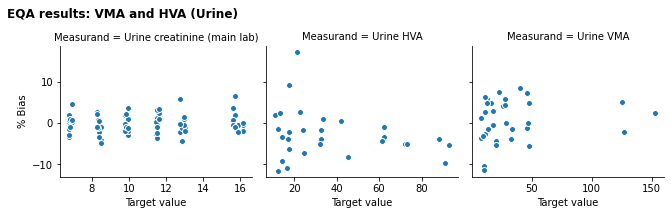

In [31]:
eqa_assay_bias_plot(eqa_data,'VMA and HVA (Urine)')

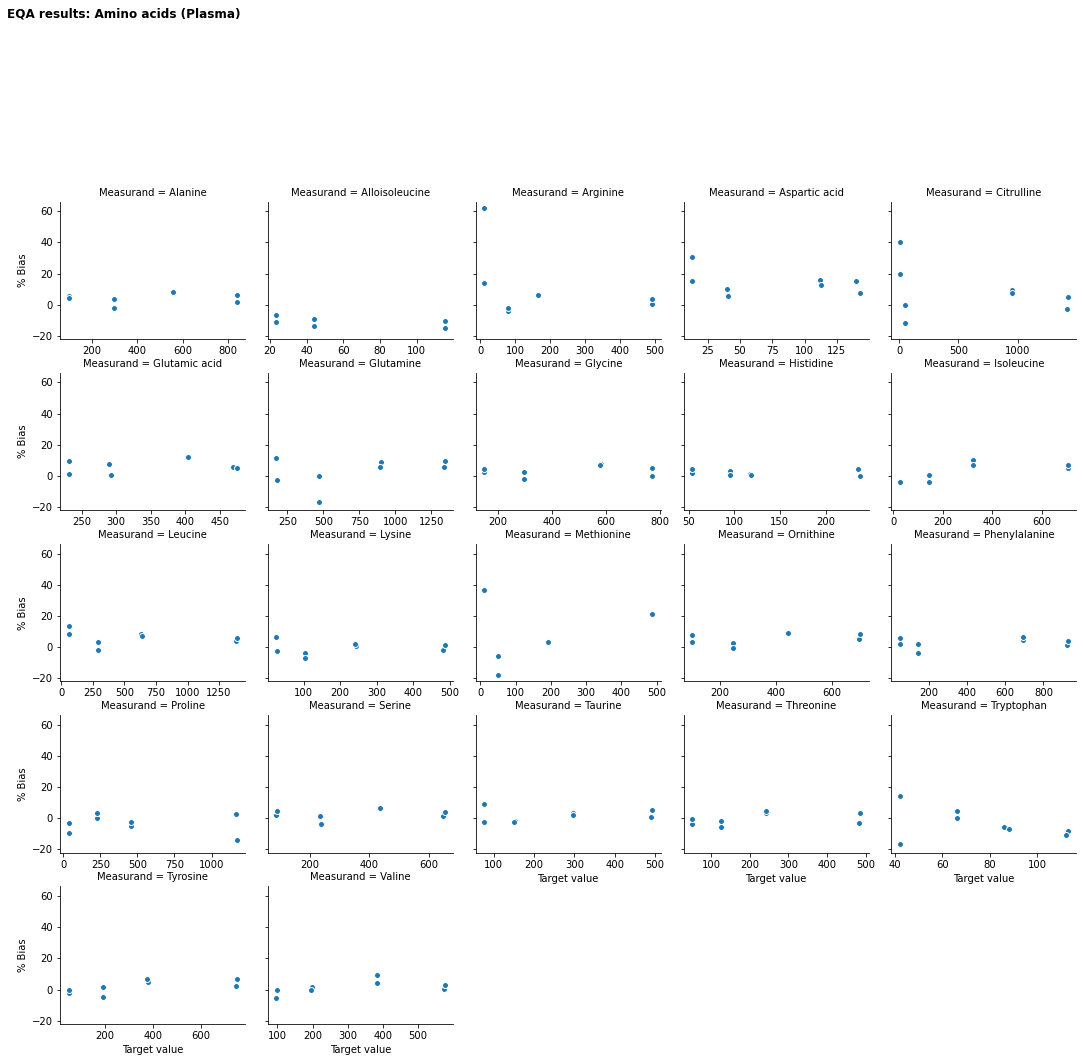

In [32]:
eqa_assay_bias_plot(eqa_data,'Amino acids (Plasma)')

In [33]:
eqa_assay_bias_plot(eqa_data,'Amino acids (CSF)')

No EQA data for Amino acids (CSF)


Next, plot for all assays in the eqa data

In [34]:
from functions import eqa_bias_multi_plot

No EQA data for Amino acids (CSF)
No EQA data for Acylcarnitines (Blood spot)
No EQA data for Chitotriosidase (Plasma)
No EQA data for Newborn screening for sickle cell disorders
No EQA data for pH (Urine)
No EQA data for nan


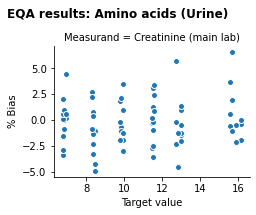

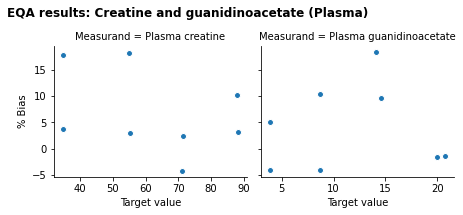

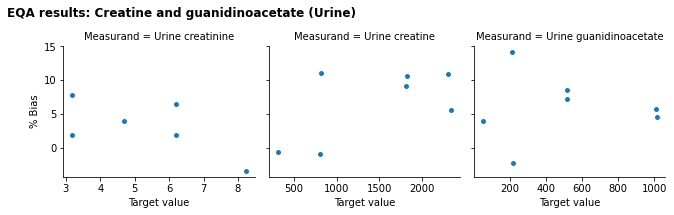

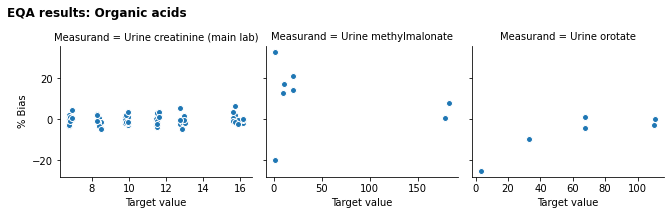

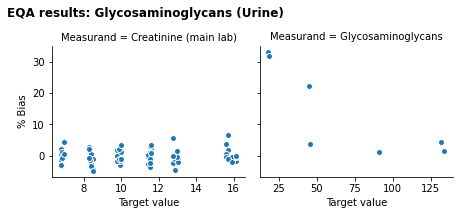

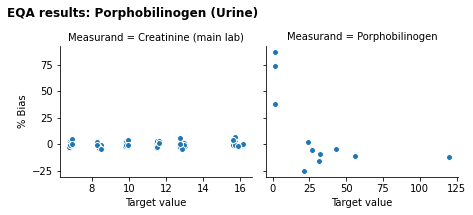

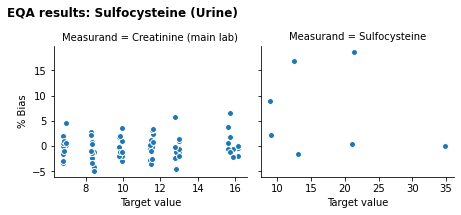

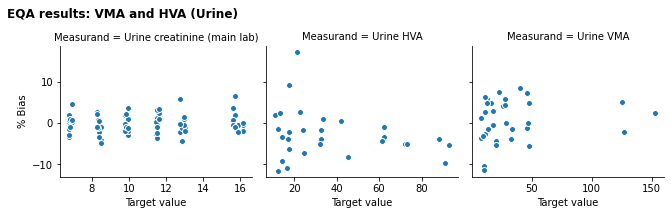

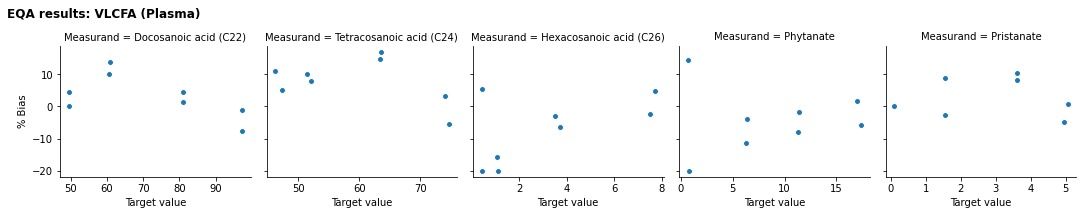

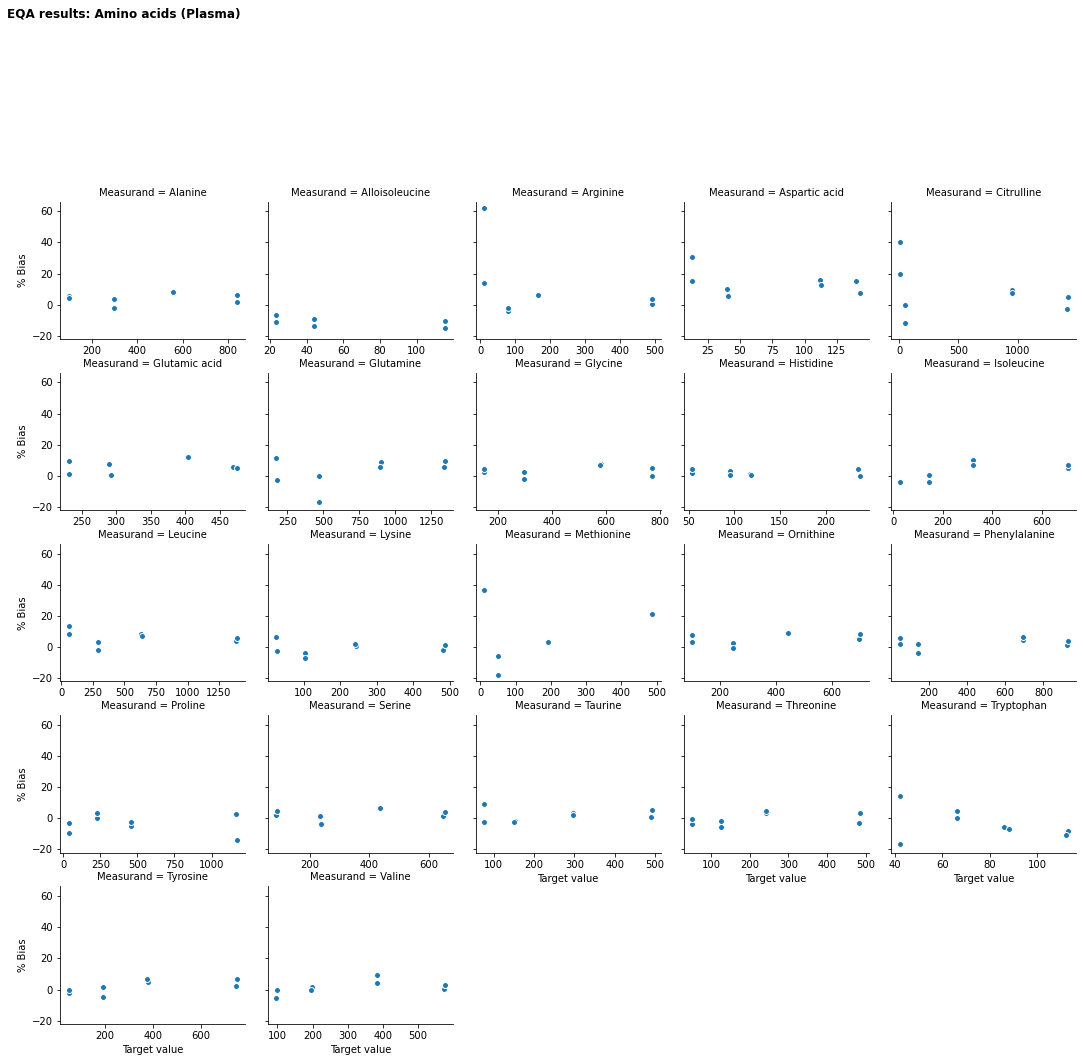

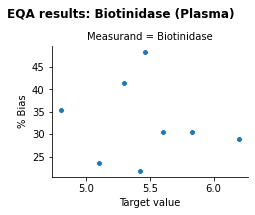

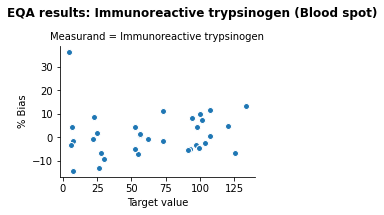

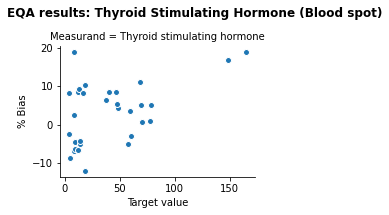

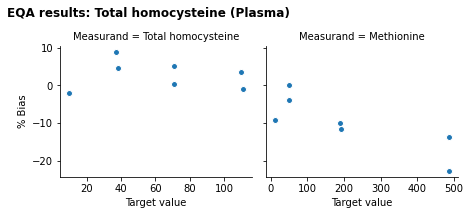

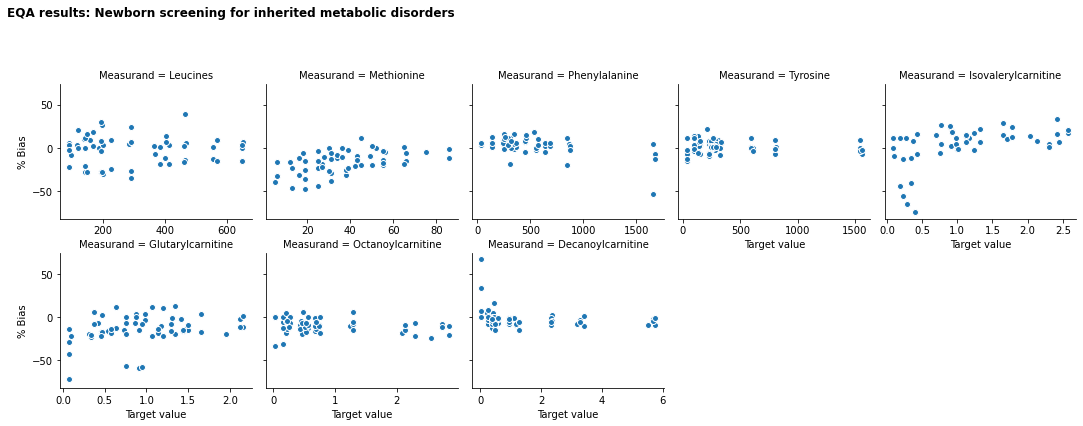

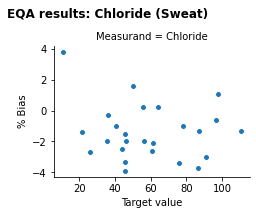

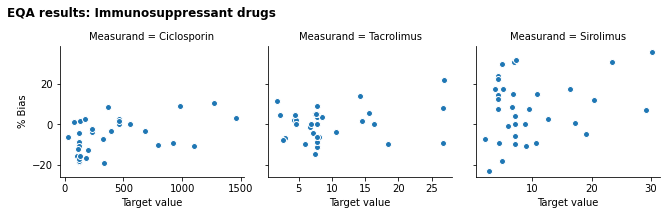

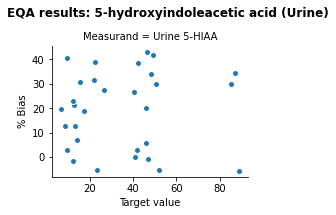

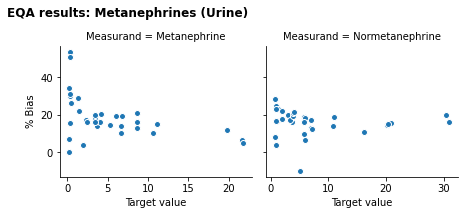

In [35]:
eqa_bias_multi_plot(eqa_data)

## Calculate EQA summary statistics

Now we can calculate aggregate statistics across all specimens and distributions. This assumes that the %bias is constant throughout the measurable range (may not be true, although the previous plots will give an indication of how valid this assumption is).

In [36]:
from functions import eqa_summary_statistics

In [37]:
eqa_data.head()

,Assay,Measurand,Order,IsRatio,ratio_numerator,ratio_denominator,Randox,Scheme name,EQA analyte name,reportable_range_lower,...,reportable_range_source,Specimen,n,Pool,Standard Uncertainty,Instrument,Result,Targ,% Bias,% uncertainty in target value
0,Amino acids (CSF),Glycine,1.0,False,NaN,NaN,Glycine Clinical Chemistry Cation exchange chromatography umol/l Biochrom (CSF),NaN,NaN,5.0,...,ADD.BIO 33965 (v2.6),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Amino acids (CSF),Serine,2.0,False,NaN,NaN,Serine Clinical Chemistry Cation exchange chromatography umol/l Biochrom (CSF),NaN,NaN,5.0,...,ADD.BIO 33965 (v2.6),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Amino acids (Urine),Alanine,1.0,False,NaN,NaN,Alanine Clinical Chemistry Cation exchange chromatography umol/l Biochrom (Urine),NaN,NaN,45.0,...,ADD.BIO 33965 (v2.6),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Amino acids (Urine),Arginine,2.0,False,NaN,NaN,Arginine Clinical Chemistry Cation exchange chromatography umol/l Biochrom (Urine),NaN,NaN,25.0,...,ADD.BIO 33965 (v2.6),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Amino acids (Urine),Aspartic acid,3.0,False,NaN,NaN,Aspartate Clinical Chemistry Cation exchange chromatography umol/l Biochrom (Urine),NaN,NaN,25.0,...,ADD.BIO 33965 (v2.6),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
eqa_summary_statistics(eqa_data,'VMA and HVA (Urine)')

,"(Specimen, count)","(Targ, min)","(Targ, max)","(% Bias, mean)","(% Bias, std)","(% uncertainty in target value, mean)","(Combined uncertainty of % bias, )",Expanded uncertainty of % bias
Measurand,,,,,,,,
Urine HVA,30,10.9,93.1,-2.95,5.85,2.69,6.44,12.88
Urine VMA,33,8,153,0.60,5,2.51,5.59,11.18
Urine creatinine (main lab),71,6.76,16.15,-0.26,2.34,1.15,2.60,5.21
Urine HVA /creatinine ratio,0,,,-2.69,,,6.94,13.89
Urine VMA/creatinine ratio,0,,,0.87,,,6.17,12.34


In [39]:
eqa_summary_statistics(eqa_data,'Newborn screening for inherited metabolic disorders')

,"(Specimen, count)","(Targ, min)","(Targ, max)","(% Bias, mean)","(% Bias, std)","(% uncertainty in target value, mean)","(Combined uncertainty of % bias, )",Expanded uncertainty of % bias
Measurand,,,,,,,,
Leucines,60,89.00,654.00,-1.91,16.27,2.81,16.51,33.03
Methionine,60,5.00,86.00,-17.17,12.94,3.90,13.52,27.04
Phenylalanine,60,34.00,1679.00,2.70,10.48,2.85,10.86,21.72
Tyrosine,60,37.00,1557.00,1.56,7.31,2.65,7.77,15.54
Isovalerylcarnitine,57,0.09,2.57,0.71,26.46,3.05,26.63,53.26
Glutarylcarnitine,59,0.07,2.16,-14.09,16.81,4.43,17.39,34.77
Octanoylcarnitine,59,0.03,2.85,-9.84,8.10,3.36,8.77,17.54
Decanoylcarnitine,59,0.03,5.76,-1.57,11.59,3.10,11.99,23.99


If there is no quantitative EQA scheme (like for acylcarnitines), the table will be blank

In [40]:
eqa_summary_statistics(eqa_data,'Acylcarnitines (Blood spot)')

,"(Specimen, count)","(Targ, min)","(Targ, max)","(% Bias, mean)","(% Bias, std)","(% uncertainty in target value, mean)","(Combined uncertainty of % bias, )",Expanded uncertainty of % bias
Measurand,,,,,,,,
Free carnitine,0,,,,,,,
C2 (Acetyl) carnitine,0,,,,,,,
C3 (Propionyl) carnitine,0,,,,,,,
C4 (Butyryl) Carnitine,0,,,,,,,
C5 (Isovaleryl) Carnitine,0,,,,,,,
C6 (Hexanoyl) Carnitine,0,,,,,,,
C8 (Octanoyl) Carnitine,0,,,,,,,
C10 (Decanoyl) Carnitine,0,,,,,,,
C14 (Myristoyl) Carnitine,0,,,,,,,


We can export the data for all assays as seperate .csv files which are saved in the \data\processed\eqa_summary_tables folder

In [41]:
from functions import assay_eqa_data_export

In [42]:
assay_eqa_data_export(eqa_data)

Amino acids (CSF) succesfully exported
Amino acids (Urine) succesfully exported
Acylcarnitines (Blood spot) succesfully exported
Chitotriosidase (Plasma) succesfully exported
Creatine and guanidinoacetate (Plasma) succesfully exported
Creatine and guanidinoacetate (Urine) succesfully exported
Newborn screening for sickle cell disorders succesfully exported
Organic acids succesfully exported
Glycosaminoglycans (Urine) succesfully exported
pH (Urine) succesfully exported
Porphobilinogen (Urine) succesfully exported
Sulfocysteine (Urine) succesfully exported
VMA and HVA (Urine) succesfully exported
VLCFA (Plasma) succesfully exported
Amino acids (Plasma) succesfully exported
Biotinidase (Plasma) succesfully exported
Immunoreactive trypsinogen (Blood spot) succesfully exported
Thyroid Stimulating Hormone (Blood spot) succesfully exported
Total homocysteine (Plasma) succesfully exported
Newborn screening for inherited metabolic disorders succesfully exported
Chloride (Sweat) succesfully exp

# Performance targets

Performance targets for each measurand are detailed in **ADD.BIO 6378**: *BGU Quality Monitoring Processes (Appendix 4)*

Import the performance targets, rename the columns and round to one decimal place.

In [43]:
from functions import load_performance_targets

In [44]:
performance_targets = load_performance_targets('data//raw_data/performance_targets_march_2021.xlsx')
performance_targets.head()

,Assay,Measurand,Anal CV Optimal,Anal CV Desirable,Anal CV Minimal,Bias Optimal,Bias Desirable,Bias Minimal,TE Optimal,TE Desirable,TE Minimal
0,Amino acids (CSF),Glycine,5.0,10.0,15.0,5.0,10.0,15.0,13.2,26.5,39.8
1,Amino acids (CSF),Serine,5.0,10.0,15.0,5.0,10.0,15.0,13.2,26.5,39.8
2,Amino acids (Plasma),Alanine,3.7,7.4,11.0,7.2,14.4,21.6,13.3,26.6,39.8
3,Amino acids (Plasma),Alloisoleucine,3.9,7.8,11.6,6.0,12.0,18.0,12.4,24.8,37.2
4,Amino acids (Plasma),Arginine,4.8,9.6,14.5,4.9,9.8,14.7,12.9,25.7,38.6


Performance against imprecision, bias and total allowable error is assessed against three targets:
* Optimal
* Desirable
* Minimal

In [45]:
from functions import performance_table

In [46]:
performance_table(qc_data, eqa_data, 'Acylcarnitines (Blood spot)', 10, performance_targets)

,% CV,CV performance,% Bias,Bias performance,Total error,TAE performance
Measurand,,,,,,
Free carnitine,6.6,Desirable,,Not evaluated,,Not evaluated
C2 (Acetyl) carnitine,4,Optimal,,Not evaluated,,Not evaluated
C3 (Propionyl) carnitine,6.04,Desirable,,Not evaluated,,Not evaluated
C4 (Butyryl) Carnitine,6.08,Desirable,,Not evaluated,,Not evaluated
C5 (Isovaleryl) Carnitine,21.43,Not met,,Not evaluated,,Not evaluated
C6 (Hexanoyl) Carnitine,6.94,Desirable,,Not evaluated,,Not evaluated
C8 (Octanoyl) Carnitine,7.36,Desirable,,Not evaluated,,Not evaluated
C10 (Decanoyl) Carnitine,12.96,Minimal,,Not evaluated,,Not evaluated
C14 (Myristoyl) Carnitine,6.62,Desirable,,Not evaluated,,Not evaluated


In [47]:
performance_table(qc_data, eqa_data, 'Amino acids (Plasma)', 10, performance_targets)

,% CV,CV performance,% Bias,Bias performance,Total error,TAE performance
Measurand,,,,,,
Alanine,3.53,Optimal,4.45,Optimal,10.3,Optimal
Alloisoleucine,3.22,Optimal,-10.95,Desirable,16.3,Desirable
Arginine,5.53,Desirable,10.81,Minimal,19.9,Desirable
Aspartic acid,5.45,Optimal,14.14,Desirable,23.1,Desirable
Citrulline,5.05,Optimal,8.30,Desirable,16.6,Desirable
Glutamic acid,6.85,Optimal,6.77,Optimal,18.1,Optimal
Glutamine,4.78,Desirable,2.70,Optimal,10.6,Desirable
Glycine,3.86,Desirable,3.39,Optimal,9.8,Optimal
Histidine,4.08,Desirable,1.95,Optimal,8.7,Desirable


In [48]:
from functions import assay_performance_data_export

In [49]:
assay_performance_data_export(qc_data, eqa_data, 10, performance_targets,combined=True)

Performance table for Amino acids (CSF) succesfully exported
Performance table for Amino acids (Plasma) succesfully exported
Performance table for Amino acids (Urine) succesfully exported
Performance table for Organic acids succesfully exported
Performance table for Glycosaminoglycans (Urine) succesfully exported
Performance table for Porphobilinogen (Urine) succesfully exported
Performance table for Sulfocysteine (Urine) succesfully exported
Performance table for VMA and HVA (Urine) succesfully exported
Performance table for Biotinidase (Plasma) succesfully exported
Performance table for Acylcarnitines (Blood spot) succesfully exported
Performance table for Immunoreactive trypsinogen (Blood spot) succesfully exported
Performance table for Thyroid Stimulating Hormone (Blood spot) succesfully exported
Performance table for Chitotriosidase (Plasma) succesfully exported
Performance table for Creatine and guanidinoacetate (Plasma) succesfully exported
Performance table for Creatine and gua